# Time Series - Lecture 2: Lags, Differencing, AR, and MA

The goal of time series is similar to regressions in that we are trying to separate **trends/patterns/model** from **resisduals/noise**. The difference is that time is a useful component in finding trends/patterns.

Today, we will study **how** time variable is used in finding patterns.

## Agenda

1. Lags and Differencing
2. Autoregression (AR)
3. Rolling Window or moving average (MA)

Let us use the same example to explore these concepts:


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

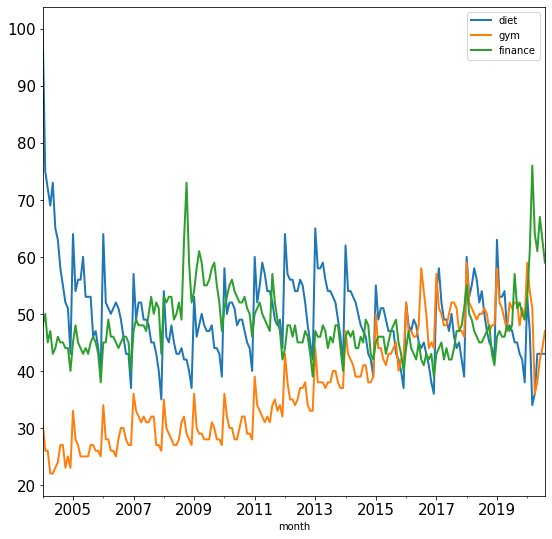

In [258]:
df = pd.read_csv('data/multiTimeline.csv', skiprows=1)
df.columns = ['month', 'diet', 'gym', 'finance']
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)
df.plot(figsize=(9,9), linewidth=2, fontsize=15)

## Lags and Differencing

### Lags
- Normally, "lag of $X_t$" is denoted $LX_t = X_{t-1}$, $L^2X_t=X_{t-2}$, and etc. 
- In data, usually create lags by shifting index by one, and normally you loose one data point

In [259]:
df.diet

month
2004-01-01    100
2004-02-01     75
2004-03-01     72
2004-04-01     69
2004-05-01     73
             ... 
2020-04-01     36
2020-05-01     43
2020-06-01     43
2020-07-01     43
2020-08-01     43
Name: diet, Length: 200, dtype: int64

In [260]:
df.diet.shift(-1)

month
2004-01-01    75.0
2004-02-01    72.0
2004-03-01    69.0
2004-04-01    73.0
2004-05-01    65.0
              ... 
2020-04-01    43.0
2020-05-01    43.0
2020-06-01    43.0
2020-07-01    43.0
2020-08-01     NaN
Name: diet, Length: 200, dtype: float64

In [261]:
df['diet1'] = df.diet.shift(-1)

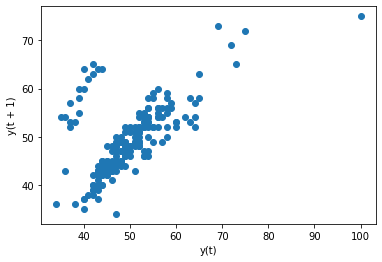

In [262]:
pd.plotting.lag_plot(df.diet,lag=1)

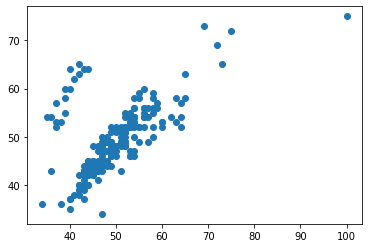

In [263]:
plt.scatter(df['diet'],df['diet1'])

### Differencing

- Change between consecutive observations, and can be written as: $$y'_t=y_t-y_{t-1}$$
- Second -order differencing: $$ \begin{align} y''_t & = y'_t-y'_{t-1} \\ & = (y_t-y_{t-1}) - (y_{t-1}-y_{t-2}) \end{align} $$
- Seasonal (or "lag-m differencing"): $$y'_t=y_t-y_{t-m}$$ where $m$ is the period for a season

In [264]:
pd.merge(diet, diet.diff(), left_index=True, right_index=True)

,diet_x,diet_y
month,,
2004-01-01,100,NaN
2004-02-01,75,-25.0
2004-03-01,72,-3.0
2004-04-01,69,-3.0
2004-05-01,73,4.0
...,...,...
2020-04-01,36,2.0
2020-05-01,43,7.0
2020-06-01,43,0.0


In [265]:
pd.merge(diet, diet.diff(periods=2), left_index=True, right_index=True)

,diet_x,diet_y
month,,
2004-01-01,100,NaN
2004-02-01,75,NaN
2004-03-01,72,-28.0
2004-04-01,69,-6.0
2004-05-01,73,1.0
...,...,...
2020-04-01,36,-11.0
2020-05-01,43,9.0
2020-06-01,43,7.0


- Differencing can eliminates (or reduces) trend and seasonality

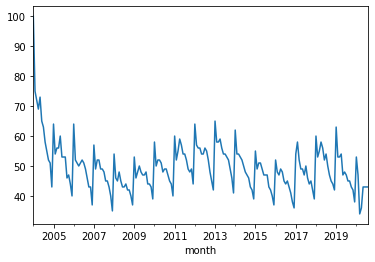

In [266]:
df['diet'].plot()

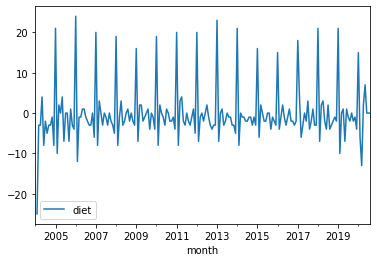

In [267]:
diet.diff().plot()

See that you have removed much of the trend and you can really see the peaks in January every year. Note: You can also perform additional data manipulations (e.g., 2nd order differencing) if the trend is not yet entirely removed. See [here](https://otexts.com/fpp2/stationarity.html) for more on differencing.

Differencing can be helpful in turning your time series into a stationary time series. 

> Stationarity: properties of the data generating process do not depend on the time at which the series is observed.

Stationary time series are useful because many time series forecasting methods are based on the assumption that the time series is approximately stationary.

More noticeable example can be found in asset prices. For example, let's look into 200 consecurive days of Google stock price and differenced value.

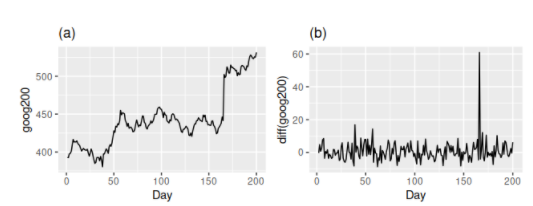

In [268]:
from PIL import Image
Image.open("images/GOOGdiff.png")

## Autoregression

- The model predicts the variable of interest using a linear combination of **historical** values of the variable. 
- An **AR(p) model** is written as:
$$y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \cdots + \beta_py_{t-p}+\epsilon_t$$

For an AR(1) model, when:

- $\beta_1=0$, the model, or $y_t$ is equivalent to noise
- $\beta_1=1$ and $\beta_0=0$, the model, or $y_t$ is equivalent to random walk 
- $\beta_1=1$ and $\beta_0 \neq 0$, the model, or $y_t$ is equivalent to random walk with a drift 
- $\beta_1<0$, $y_t$ tends to oscillate around the mean

We normally use autoregressive models for the following stationary cases:
- for an AR(1) model, $-1<\beta_1<1$
- for an AR(2) model, $-1<\beta_2<1,\beta_1+\beta_2<1,\beta_2-\beta_1<1$

when $p\geq3$, the conditions are more complicated.

In [269]:
df.index = pd.DatetimeIndex(df.index).to_period('M')

In [270]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(df.diet, order=(1,0))
result = model.fit()
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                   diet   No. Observations:                  200
Model:                     ARMA(1, 0)   Log Likelihood                -652.941
Method:                       css-mle   S.D. of innovations              6.323
Date:                Sun, 20 Sep 2020   AIC                           1311.882
Time:                        21:16:41   BIC                           1321.777
Sample:                    01-31-2004   HQIC                          1315.887
                         - 08-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1298      1.359     36.888      0.000      47.466      52.793
ar.L1.diet     0.6730      0.063     10.754      0.000       0.550       0.796
                                    Roots           

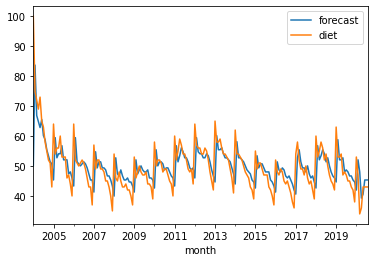

In [271]:
result.plot_predict(start='2004-01-01',end='2020-08-01')
plt.show()

In [272]:
df.index

PeriodIndex(['2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06',
             '2004-07', '2004-08', '2004-09', '2004-10',
             ...
             '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
             '2020-05', '2020-06', '2020-07', '2020-08'],
            dtype='period[M]', name='month', length=200, freq='M')

## Moving Average (or Rolling Window)
- Rather than using the past values, a moving average model uses past **errors** in a regression.
- An **MA(q) model** is written as: $$y_t=\beta_0+\epsilon_t+\beta_1\epsilon_{t-1}+\cdots+\beta_q\epsilon_{t-q}$$

We normally use moving average models for the following (invertibility) cases:
- for an MA(1) model, $-1<\beta_1<1$
- for an MA(2) model, $-1<\beta_2<1,\beta_1+\beta_2>-1,\beta_1-\beta_2<1$

when $p\geq3$, the conditions are more complicated.

                              ARMA Model Results                              
Dep. Variable:                   diet   No. Observations:                  200
Model:                     ARMA(0, 7)   Log Likelihood                -628.329
Method:                       css-mle   S.D. of innovations              5.492
Date:                Sun, 20 Sep 2020   AIC                           1274.658
Time:                        21:16:43   BIC                           1304.343
Sample:                    01-31-2004   HQIC                          1286.671
                         - 08-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3819      1.709     29.483      0.000      47.033      53.731
ma.L1.diet     0.4635      0.089      5.205      0.000       0.289       0.638
ma.L2.diet     0.5038      0.064      7.921      0.0

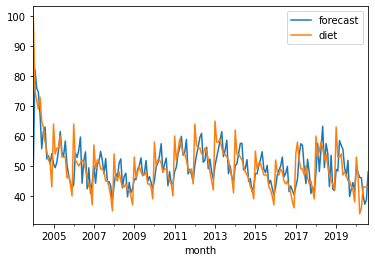

In [273]:
model = ARMA(df.diet, order=(0,7))
result = model.fit()
print(result.summary())
result.plot_predict(start='2004-01-01',end='2020-08-01')
plt.show()

## Recap:
- You've learned the concepts of lags, autocorrelation, and differences.
- You've leraned to visualize the relationships for easier interpretation/undertanding.
- You've learned the theory of AR and MA models.
- You've implemented, interpreted, and visualized the AR and MA models in Python.


## Up next:
Deeper look at time series modeling by further learn inaddition to AR and MA model
- ARMA models
- ARIMA models

# Activities

All of the activities below should be done with your chosen data set. 

1. Graph lag, ACF, PACF, and difference (play around with different hyperparameters such as lags) to create interpretation/intuition about your data set.
2. Which model do you think will be appropriate to estimate given your data? Briefly talk through your logic.
3. Code AR models (play around with different hypterparameters), and visualize.
4. Code MA models (play around with different hypterparameters), and visuzlize.

## References

The materials presented here are inspired and modified from the following sources:
- https://otexts.com/fpp2/
- https://github.com/CodeOp-tech/tsa-soyhyoj/blob/master/New_Years_Resolutions_Workshop.ipynb
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- https://s3.amazonaws.com/assets.datacamp.com/production/course_4267/slides/chapter3.pdf